## Convolution on GPU

If you encounter any errors while using nvcc4jupyter, please visit the GitHub repository for assistance: https://github.com/andreinechaev/nvcc4jupyter.

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-_2vltwbk
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-_2vltwbk
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 4664a4ef472c35ed55ab1a53c458aa48e6f9919d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.0-py3-none-any.whl size=9547 sha256=64a55f2049c7c9bfcac7588e0c57c933a3985d27e1c4cd4ca385fb9c91e846d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-zxm1tkpy/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter


In [ ]:
!nvidia-smi

Sat Mar 23 16:59:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvidia-smi -h

NVIDIA System Management Interface -- v535.104.05

NVSMI provides monitoring information for Tesla and select Quadro devices.
The data is presented in either a plain text or an XML format, via stdout or a file.
NVSMI also provides several management operations for changing the device state.

Note that the functionality of NVSMI is exposed through the NVML C-based
library. See the NVIDIA developer website for more information about NVML.
Python wrappers to NVML are also available.  The output of NVSMI is
not guaranteed to be backwards compatible; NVML and the bindings are backwards
compatible.

http://developer.nvidia.com/nvidia-management-library-nvml/
http://pypi.python.org/pypi/nvidia-ml-py/
Supported products:
- Full Support
    - All Tesla products, starting with the Kepler architecture
    - All Quadro products, starting with the Kepler architecture
    - All GRID products, starting with the Kepler architecture
    - GeForce Titan products, starting with the Kepler architecture
- 

In [ ]:
%load_ext nvcc4jupyter

Source files will be saved in "/tmp/tmp_p9yf655".


### 2D Array

In [ ]:
%%cuda

#include <iostream>
#include <cstdlib>
#include <cuda_runtime.h>

// Define Kernel Configuration Parameters
#define KERNEL_RADIUS 8
#define KERNEL_W (2 * KERNEL_RADIUS + 1)
__device__ __constant__ float d_Kernel[KERNEL_W];

#define TILE_W 16    // active cell width
#define TILE_H 16    // active cell height
#define TILE_SIZE (TILE_W + KERNEL_RADIUS * 2) * (TILE_W + KERNEL_RADIUS * 2)

#define IMUL(a, b) __mul24(a, b)

////////////////////////////////////////////////////////////////////////////////
// Row convolution filter
////////////////////////////////////////////////////////////////////////////////
__global__ void convolutionRowGPU(
    float *d_Result,
    float *d_Data,
    int dataW,
    int dataH
)
{
    // Data cache: threadIdx.x , threadIdx.y
    __shared__ float data[TILE_H * (TILE_W + KERNEL_RADIUS * 2)];

    // global mem address of this thread
    const int gLoc = threadIdx.x +
                      IMUL(blockIdx.x, blockDim.x) +
                      IMUL(threadIdx.y, dataW) +
                      IMUL(blockIdx.y, blockDim.y) * dataW;

    // load cache (32x16 shared memory, 16x16 threads blocks)
    // each thread loads two values from global memory into shared mem
    // if in image area, get value in global mem, else 0
    int x; // image based coordinate

    // original image based coordinate
    const int x0 = threadIdx.x + IMUL(blockIdx.x, blockDim.x);
    const int shift = threadIdx.y * (TILE_W + KERNEL_RADIUS * 2);

    // case1: left
    x = x0 - KERNEL_RADIUS;
    if (x < 0)
        data[threadIdx.x + shift] = 0;
    else
        data[threadIdx.x + shift] = d_Data[gLoc - KERNEL_RADIUS];

    // case2: right
    x = x0 + KERNEL_RADIUS;
    if (x > dataW - 1)
        data[threadIdx.x + blockDim.x + shift] = 0;
    else
        data[threadIdx.x + blockDim.x + shift] = d_Data[gLoc + KERNEL_RADIUS];

    __syncthreads();

    // convolution
    float sum = 0;
    x = KERNEL_RADIUS + threadIdx.x;
    for (int i = -KERNEL_RADIUS; i <= KERNEL_RADIUS; i++)
        sum += data[x + i + shift] * d_Kernel[KERNEL_RADIUS + i];

    d_Result[gLoc] = sum;
}

////////////////////////////////////////////////////////////////////////////////
// Column convolution filter
////////////////////////////////////////////////////////////////////////////////
__global__ void convolutionColGPU(
    float *d_Result,
    float *d_Data,
    int dataW,
    int dataH
)
{
    // Data cache: threadIdx.x , threadIdx.y
    __shared__ float data[TILE_W * (TILE_H + KERNEL_RADIUS * 2)];

    // global mem address of this thread
    const int gLoc = threadIdx.x +
                      IMUL(blockIdx.x, blockDim.x) +
                      IMUL(threadIdx.y, dataW) +
                      IMUL(blockIdx.y, blockDim.y) * dataW;

    // load cache (32x16 shared memory, 16x16 threads blocks)
    // each thread loads two values from global memory into shared mem
    // if in image area, get value in global mem, else 0
    int y; // image based coordinate

    // original image based coordinate
    const int y0 = threadIdx.y + IMUL(blockIdx.y, blockDim.y);
    const int shift = threadIdx.y * (TILE_W);

    // case1: upper
    y = y0 - KERNEL_RADIUS;
    if (y < 0)
        data[threadIdx.x + shift] = 0;
    else
        data[threadIdx.x + shift] = d_Data[gLoc - IMUL(dataW, KERNEL_RADIUS)];

    // case2: lower
    y = y0 + KERNEL_RADIUS;
    const int shift1 = shift + IMUL(blockDim.y, TILE_W);
    if (y > dataH - 1)
        data[threadIdx.x + shift1] = 0;
    else
        data[threadIdx.x + shift1] = d_Data[gLoc + IMUL(dataW, KERNEL_RADIUS)];

    __syncthreads();

    // convolution
    float sum = 0;
    for (int i = 0; i <= KERNEL_RADIUS * 2; i++)
        sum += data[threadIdx.x + (threadIdx.y + i) * TILE_W] * d_Kernel[i];

    d_Result[gLoc] = sum;
}

int main() {

    // Set image dimensions
    const int dataW = 3;
    const int dataH = 3;

    // Allocate host memory
    float *h_Data = new float[dataW * dataH];

    // Initialize input data (random values)
    for (int i = 0; i < dataW * dataH; ++i) {
        h_Data[i] = rand() % 9;
    }

    // Print original data
    std::cout << "Original Data:" << std::endl;
    for (int i = 0; i < dataH; ++i) {
        for (int j = 0; j < dataW; ++j) {
            std::cout << h_Data[i * dataW + j] << " ";
        }
        std::cout << std::endl;
    }

    // Allocate device memory
    float *d_Data, *d_Result;
    cudaMalloc((void**)&d_Data, sizeof(float) * dataW * dataH);
    cudaMalloc((void**)&d_Result, sizeof(float) * dataW * dataH);

    // Copy input data from host to device
    cudaMemcpy(d_Data, h_Data, sizeof(float) * dataW * dataH, cudaMemcpyHostToDevice);

    // Gaussian blur kernel
    const float h_GaussianKernel[KERNEL_W] = {
        4, 3, 2, 1, 0, 1, 2, 3, 4
    };

    // Copy convolution kernel to constant memory
    cudaMemcpyToSymbol(d_Kernel, h_GaussianKernel, sizeof(float) * KERNEL_W);

    // Set up kernel grid and block dimensions
    dim3 dimBlock(TILE_W, TILE_H);
    dim3 dimGrid((dataW + dimBlock.x - 1) / dimBlock.x, (dataH + dimBlock.y - 1) / dimBlock.y);

    // Launch row convolution kernel
    convolutionRowGPU<<<dimGrid, dimBlock>>>(d_Result, d_Data, dataW, dataH);
    cudaDeviceSynchronize(); // Ensure the row convolution kernel completes

    // Launch column convolution kernel
    convolutionColGPU<<<dimGrid, dimBlock>>>(d_Result, d_Data, dataW, dataH);
    cudaDeviceSynchronize(); // Ensure the column convolution kernel completes

    // Copy result data from device to host
    cudaMemcpy(h_Data, d_Result, sizeof(float) * dataW * dataH, cudaMemcpyDeviceToHost);

    // Print convolved data
    std::cout << "\nConvolved Data:" << std::endl;
    for (int i = 0; i < dataH; ++i) {
        for (int j = 0; j < dataW; ++j) {
            std::cout << h_Data[i * dataW + j] << " ";
        }
        std::cout << std::endl;
    }

    // Free allocated memory
    delete[] h_Data;
    cudaFree(d_Data);
    cudaFree(d_Result);

    return 0;
}

Original Data:
1 7 0 
7 5 7 
1 3 6 

Convolved Data:
4 28 0 
28 20 28 
27 41 45 



### Images

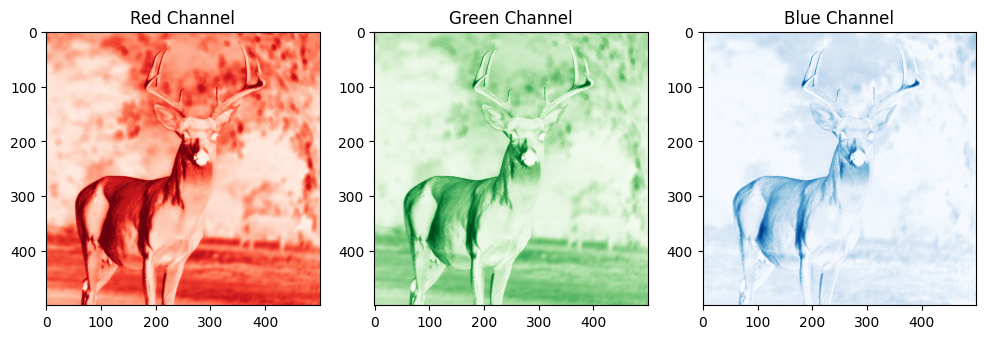

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load a JPEG image into a NumPy array
image_path = '/content/Deer.jpg'  # Replace with the actual path to your JPEG image
image = Image.open(image_path)
rgb_image_array = np.array(image)

# Separate RGB channels
red_channel = rgb_image_array[..., 0]
green_channel = rgb_image_array[..., 1]
blue_channel = rgb_image_array[..., 2]

# Display each channel
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')

plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')

plt.show()

# Save each channel to a text file
np.savetxt('/content/red_channel.txt', red_channel, fmt='%d')
np.savetxt('/content/green_channel.txt', green_channel, fmt='%d')
np.savetxt('/content/blue_channel.txt', blue_channel, fmt='%d')

In [ ]:
%%cuda

#include <iostream>
#include <fstream>
#include <cstdlib>
#include <cuda_runtime.h>

// Define Kernel Configuration Parameters
#define KERNEL_RADIUS 8
#define KERNEL_W (2 * KERNEL_RADIUS + 1)
__device__ __constant__ float d_Kernel[KERNEL_W];

#define TILE_W 16    // active cell width
#define TILE_H 16    // active cell height
#define TILE_SIZE (TILE_W + KERNEL_RADIUS * 2) * (TILE_W + KERNEL_RADIUS * 2)

#define IMUL(a, b) __mul24(a, b)

////////////////////////////////////////////////////////////////////////////////
// Row convolution filter
////////////////////////////////////////////////////////////////////////////////
__global__ void convolutionRowGPU(
    float *d_Result,
    float *d_Data,
    int dataW,
    int dataH
)
{
    // Data cache: threadIdx.x , threadIdx.y
    __shared__ float data[TILE_H * (TILE_W + KERNEL_RADIUS * 2)];

    // global mem address of this thread
    const int gLoc = threadIdx.x +
                      IMUL(blockIdx.x, blockDim.x) +
                      IMUL(threadIdx.y, dataW) +
                      IMUL(blockIdx.y, blockDim.y) * dataW;

    // load cache (32x16 shared memory, 16x16 threads blocks)
    // each thread loads two values from global memory into shared mem
    // if in image area, get value in global mem, else 0
    int x; // image based coordinate

    // original image based coordinate
    const int x0 = threadIdx.x + IMUL(blockIdx.x, blockDim.x);
    const int shift = threadIdx.y * (TILE_W + KERNEL_RADIUS * 2);

    // case1: left
    x = x0 - KERNEL_RADIUS;
    if (x < 0)
        data[threadIdx.x + shift] = 0;
    else
        data[threadIdx.x + shift] = d_Data[gLoc - KERNEL_RADIUS];

    // case2: right
    x = x0 + KERNEL_RADIUS;
    if (x > dataW - 1)
        data[threadIdx.x + blockDim.x + shift] = 0;
    else
        data[threadIdx.x + blockDim.x + shift] = d_Data[gLoc + KERNEL_RADIUS];

    __syncthreads();

    // convolution
    float sum = 0;
    x = KERNEL_RADIUS + threadIdx.x;
    for (int i = -KERNEL_RADIUS; i <= KERNEL_RADIUS; i++)
        sum += data[x + i + shift] * d_Kernel[KERNEL_RADIUS + i];

    d_Result[gLoc] = sum;
}

////////////////////////////////////////////////////////////////////////////////
// Column convolution filter
////////////////////////////////////////////////////////////////////////////////
__global__ void convolutionColGPU(
    float *d_Result,
    float *d_Data,
    int dataW,
    int dataH
)
{
    // Data cache: threadIdx.x , threadIdx.y
    __shared__ float data[TILE_W * (TILE_H + KERNEL_RADIUS * 2)];

    // global mem address of this thread
    const int gLoc = threadIdx.x +
                      IMUL(blockIdx.x, blockDim.x) +
                      IMUL(threadIdx.y, dataW) +
                      IMUL(blockIdx.y, blockDim.y) * dataW;

    // load cache (32x16 shared memory, 16x16 threads blocks)
    // each thread loads two values from global memory into shared mem
    // if in image area, get value in global mem, else 0
    int y; // image based coordinate

    // original image based coordinate
    const int y0 = threadIdx.y + IMUL(blockIdx.y, blockDim.y);
    const int shift = threadIdx.y * (TILE_W);

    // case1: upper
    y = y0 - KERNEL_RADIUS;
    if (y < 0)
        data[threadIdx.x + shift] = 0;
    else
        data[threadIdx.x + shift] = d_Data[gLoc - IMUL(dataW, KERNEL_RADIUS)];

    // case2: lower
    y = y0 + KERNEL_RADIUS;
    const int shift1 = shift + IMUL(blockDim.y, TILE_W);
    if (y > dataH - 1)
        data[threadIdx.x + shift1] = 0;
    else
        data[threadIdx.x + shift1] = d_Data[gLoc + IMUL(dataW, KERNEL_RADIUS)];

    __syncthreads();

    // convolution
    float sum = 0;
    for (int i = 0; i <= KERNEL_RADIUS * 2; i++)
        sum += data[threadIdx.x + (threadIdx.y + i) * TILE_W] * d_Kernel[i];

    d_Result[gLoc] = sum;
}

void performConvolution(const std::string& inputFileName, const std::string& outputFileName) {
    // Set image dimensions
    const int dataW = 500;
    const int dataH = 500;

    // Allocate host memory
    float *h_Data = new float[dataW * dataH];
    float *h_Result = new float[dataW * dataH];

    // Read input data from a text file
    std::ifstream inputFile(inputFileName);

    if (!inputFile.is_open()) {
        std::cerr << "Error opening the input file.\n";
        return;
    }

    // Read data from the file into the host array
    for (int i = 0; i < dataH; ++i) {
        for (int j = 0; j < dataW; ++j) {
            inputFile >> h_Data[i * dataW + j];
        }
    }

    // Close the input file
    inputFile.close();

    // Allocate device memory
    float *d_Data, *d_Result;
    cudaMalloc((void**)&d_Data, sizeof(float) * dataW * dataH);
    cudaMalloc((void**)&d_Result, sizeof(float) * dataW * dataH);

    // Copy input data from host to device
    cudaMemcpy(d_Data, h_Data, sizeof(float) * dataW * dataH, cudaMemcpyHostToDevice);

    // Gaussian blur kernel
    const float h_GaussianKernel[KERNEL_W] = {
        16, 9, 4, 1, 0, 1, 4, 9, 16
    };

    // Copy convolution kernel to constant memory
    cudaMemcpyToSymbol(d_Kernel, h_GaussianKernel, sizeof(float) * KERNEL_W);

    // Set up kernel grid and block dimensions
    dim3 dimBlock(TILE_W, TILE_H);
    dim3 dimGrid((dataW + dimBlock.x - 1) / dimBlock.x, (dataH + dimBlock.y - 1) / dimBlock.y);

    // CUDA events for timing
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Record start event
    cudaEventRecord(start);

    // Launch row convolution kernel
    convolutionRowGPU<<<dimGrid, dimBlock>>>(d_Result, d_Data, dataW, dataH);
    cudaDeviceSynchronize(); // Ensure the row convolution kernel completes

    // Launch column convolution kernel
    convolutionColGPU<<<dimGrid, dimBlock>>>(d_Result, d_Data, dataW, dataH);
    cudaDeviceSynchronize(); // Ensure the column convolution kernel completes

    // Record stop event
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    // Calculate elapsed time
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    std::cout << "Time taken: for 500 x 500 Data " << milliseconds << " ms" << std::endl;

    // Destroy CUDA events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    // Copy result data from device to host
    cudaMemcpy(h_Result, d_Result, sizeof(float) * dataW * dataH, cudaMemcpyDeviceToHost);

    // Save convolved data to a text file
    std::ofstream outputFile(outputFileName);

    if (!outputFile.is_open()) {
        std::cerr << "Error opening the output file.\n";
        return;
    }

    // Write data to the file
    for (int i = 0; i < dataH; ++i) {
        for (int j = 0; j < dataW; ++j) {
            outputFile << h_Result[i * dataW + j] << " ";
        }
        outputFile << std::endl;
    }

    // Close the output file
    outputFile.close();

    // Free allocated memory
    delete[] h_Data;
    delete[] h_Result;
    cudaFree(d_Data);
    cudaFree(d_Result);
}

int main() {
    // Call performConvolution for red_channel.txt
    std::string redInputFileName = "/content/red_channel.txt";
    std::string redOutputFileName = "/content/red_channel_after_convolution.txt";
    performConvolution(redInputFileName, redOutputFileName);

    // Call performConvolution for green_channel.txt
    std::string greenInputFileName = "/content/green_channel.txt";
    std::string greenOutputFileName = "/content/green_channel_after_convolution.txt";
    performConvolution(greenInputFileName, greenOutputFileName);

    // Call performConvolution for blue_channel.txt
    std::string blueInputFileName = "/content/blue_channel.txt";
    std::string blueOutputFileName = "/content/blue_channel_after_convolution.txt";
    performConvolution(blueInputFileName, blueOutputFileName);

    return 0;
}

Time taken: for 500 x 500 Data 0.145312 ms
Time taken: for 500 x 500 Data 0.086048 ms
Time taken: for 500 x 500 Data 0.084096 ms



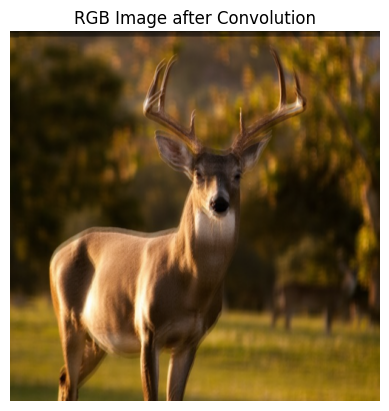

RGB Image after convolution saved to /content/deer_after_convolution.jpg


In [ ]:
import numpy as np
from PIL import Image

# Function to read and normalize the data from the convolution result file
def read_and_normalize(file_path):
    # Read data from the text file into a NumPy array
    image_data = np.loadtxt(file_path)

    # Normalize the data to the range [0, 1]
    normalized_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    return normalized_data

# Define the paths to your convolution result files
red_channel_path = "/content/red_channel_after_convolution.txt"
green_channel_path = "/content/green_channel_after_convolution.txt"
blue_channel_path = "/content/blue_channel_after_convolution.txt"

# Read and normalize data from each channel
red_channel = read_and_normalize(red_channel_path)
green_channel = read_and_normalize(green_channel_path)
blue_channel = read_and_normalize(blue_channel_path)

# Stack the channels to produce an RGB image
rgb_image = np.dstack((red_channel, green_channel, blue_channel))

# Convert the array to uint8
rgb_image_uint8 = (rgb_image * 255).astype(np.uint8)

# Create an image from the array using Pillow
rgb_image_pil = Image.fromarray(rgb_image_uint8)

# Plot the RGB image
plt.imshow(rgb_image_uint8)
plt.title('RGB Image after Convolution')
plt.axis('off')  # Turn off axis
plt.show()

# Save the RGB image
output_path_rgb = '/content/deer_after_convolution.jpg'
rgb_image_pil.save(output_path_rgb)
print(f"RGB Image after convolution saved to {output_path_rgb}")

To achieve an even stronger blur effect, you can increase the central values of the Gaussian blur kernel even more.

## LENET-5 x mnist

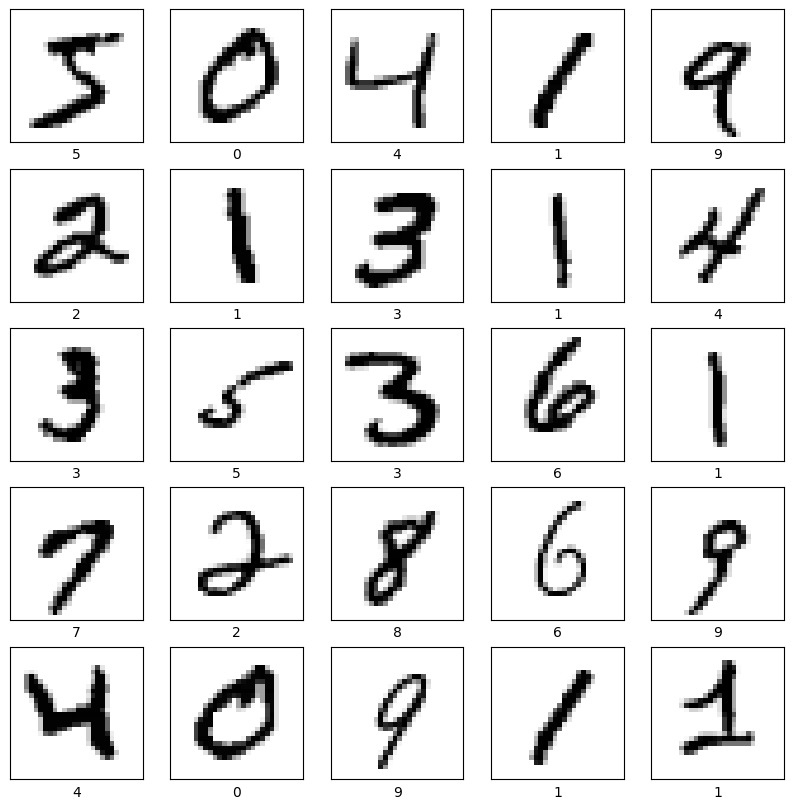

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Download MNIST dataset and Save in File Locally
(x_train, y_train), (x_test, y_test) = mnist.load_data()
np.savez("mnist_dataset.npz", x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

# Load dataset from file
data = np.load("mnist_dataset.npz")
x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Show some example images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

### Train, Validate, Test (60, 20, 20)

In [ ]:
# Load MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape data for LeNet-5 input
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Calculate split sizes
num_samples = len(x_train_full)
train_size = int(0.6 * num_samples)
val_size = int(0.2 * num_samples)

# Split data into train, validation, and test sets
x_train, x_val, x_test = (
    x_train_full[:train_size],
    x_train_full[train_size:train_size + val_size],
    x_train_full[train_size + val_size:]
)
y_train, y_val, y_test = (
    y_train_full[:train_size],
    y_train_full[train_size:train_size + val_size],
    y_train_full[train_size + val_size:]
)

# Define LeNet-5 model
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
x_train.shape,x_val.shape,x_test.shape

((36000, 28, 28, 1), (12000, 28, 28, 1), (12000, 28, 28, 1))

### Model Summary

In [ ]:
# Function to calculate parameters in a model
def calculate_parameters(model):
    parameter_counts = []
    for layer in model.layers:
        if hasattr(layer, 'weights'):
            num_params = sum(p.numpy().size for p in layer.weights)
            parameter_counts.append(num_params)
        else:
            parameter_counts.append(0)
    return parameter_counts

# Function to calculate activation sizes in a model
def calculate_activation_sizes(model):
    activation_sizes = []
    for layer in model.layers:
        if layer.output_shape is not None:
            activation_size = 1
            for dim in layer.output_shape[1:]:  # Exclude batch dimension
                activation_size *= dim
            activation_sizes.append(activation_size)
        else:
            activation_sizes.append(0)
    return activation_sizes

def summary(model):
    print("\nModel Summary:")

    parameters = calculate_parameters(model)
    activation_sizes = calculate_activation_sizes(model)
    total_params = sum(parameters)

    print("\n{:<25}  {:>10}  {:>16}  {:>16}".format('Layer Name', 'Parameters', 'Output Shape', 'Activation Size'))
    for i in range(len(model.layers)):
        layer_name = model.layers[i].name
        output_shape = model.layers[i].output_shape[1:] if model.layers[i].output_shape else "No output shape"
        output_shape_str = 'x'.join(str(dim) for dim in output_shape)
        print("{:<25} {:>11}  {:>16} {:>16}".format(layer_name, parameters[i], output_shape_str, activation_sizes[i]))

    print("\nTotal Parameters:", total_params)

# Print the summary of the model
summary(model)


Model Summary:

Layer Name                 Parameters      Output Shape   Activation Size
conv2d                            156           24x24x6             3456
average_pooling2d                   0           12x12x6              864
conv2d_1                         2416            8x8x16             1024
average_pooling2d_1                 0            4x4x16              256
flatten                             0               256              256
dense                           30840               120              120
dense_1                         10164                84               84
dense_2                           850                10               10

Total Parameters: 44426


### Training

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
282/282 [==============================] - 6s 7ms/step - loss: 0.5344 - accuracy: 0.8386 - val_loss: 0.2583 - val_accuracy: 0.9212
Epoch 2/10
282/282 [==============================] - 1s 5ms/step - loss: 0.1749 - accuracy: 0.9459 - val_loss: 0.1463 - val_accuracy: 0.9563
Epoch 3/10
282/282 [==============================] - 1s 5ms/step - loss: 0.1110 - accuracy: 0.9661 - val_loss: 0.1082 - val_accuracy: 0.9669
Epoch 4/10
282/282 [==============================] - 1s 5ms/step - loss: 0.0847 - accuracy: 0.9737 - val_loss: 0.0971 - val_accuracy: 0.9705
Epoch 5/10
282/282 [==============================] - 1s 4ms/step - loss: 0.0704 - accuracy: 0.9784 - val_loss: 0.0924 - val_accuracy: 0.9712
Epoch 6/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0627 - accuracy: 0.9801 - val_loss: 0.0826 - val_accuracy: 0.9759
Epoch 7/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0515 - accuracy: 0.9837 - val_loss: 0.0764 - val_accuracy: 0.9773
Epoch 

### Testing

10210
1/1 [==============================] - 0s 17ms/step
2643
1/1 [==============================] - 0s 16ms/step
3397
1/1 [==============================] - 0s 16ms/step
8200
1/1 [==============================] - 0s 27ms/step
7569
1/1 [==============================] - 0s 46ms/step
11064
1/1 [==============================] - 0s 28ms/step
11004
1/1 [==============================] - 0s 57ms/step
1742
1/1 [==============================] - 0s 31ms/step


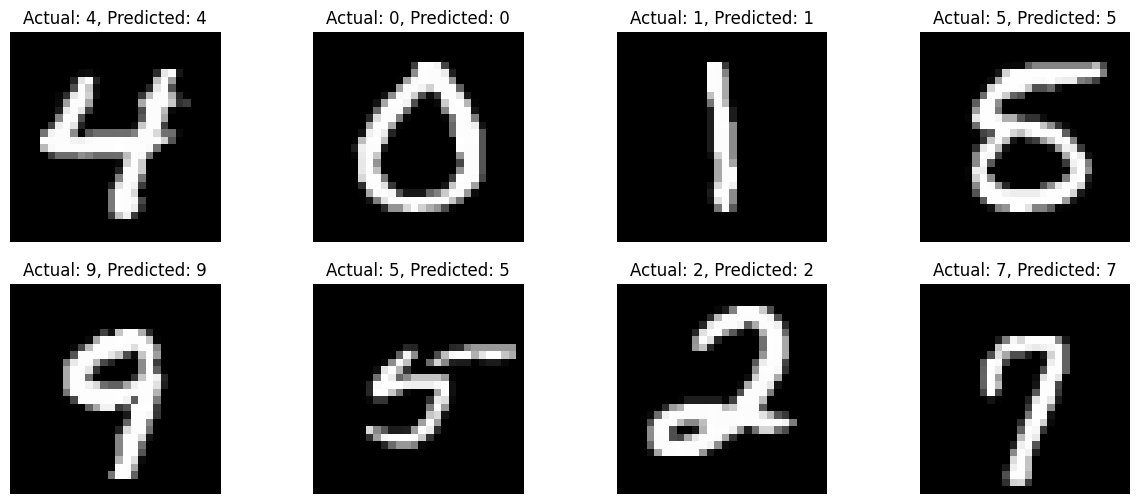

In [ ]:
import random

num_images_to_visualize = 8
plt.figure(figsize=(15, 6))
for i in range(num_images_to_visualize):
    random_index = random.randint(0, 12000)  # Generate a random index within the specified range
    plt.subplot(2, num_images_to_visualize//2, i+1)
    plt.imshow(x_test[random_index].reshape(28, 28), cmap='gray')
    print(random_index)
    plt.title(f'Actual: {y_test[random_index]}, Predicted: {np.argmax(model.predict(np.expand_dims(x_test[random_index], axis=0)))}')
    plt.axis('off')
plt.show()


### Internal View of Images Inside Model Pipeline

1/1 [==============================] - 0s 78ms/step
Size of Feature Maps: (24, 24, 6)


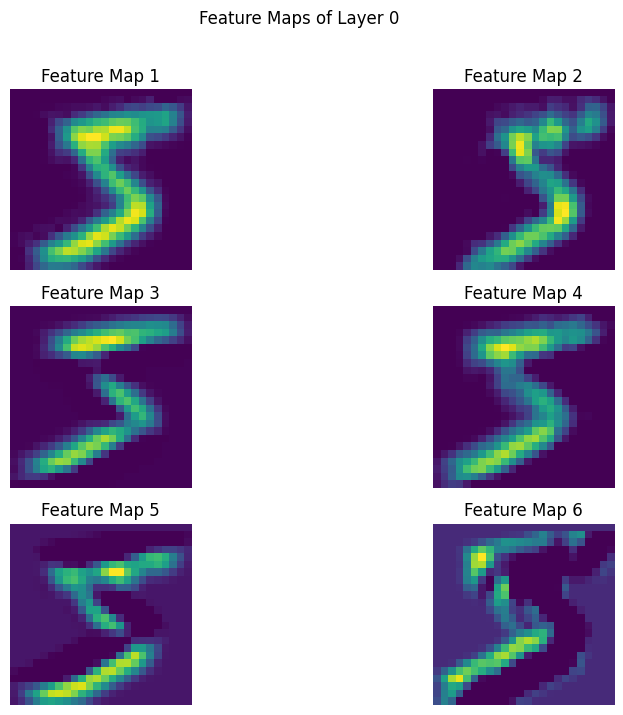

In [ ]:
def visualize_feature_maps(model, input_image, layer_index):
    # Define a new model to get intermediate layer outputs
    activation_model = Model(inputs=model.input, outputs=model.layers[layer_index].output)

    # Predict with the input image
    activation_maps = activation_model.predict(np.expand_dims(input_image, axis=0))

    # Extract feature maps from the specified layer
    feature_maps = activation_maps[0]  # Output shape: (height, width, num_filters)

    # Print the size of the feature maps
    print(f"Size of Feature Maps: {feature_maps.shape}")

    # Plot the feature maps
    num_filters = feature_maps.shape[-1]
    cols = int(np.sqrt(num_filters))
    rows = int(np.ceil(num_filters / cols))

    plt.figure(figsize=(10, 8))
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_maps[:, :, i], cmap='viridis')
        plt.title(f'Feature Map {i + 1}')
        plt.axis('off')
    plt.suptitle(f'Feature Maps of Layer {layer_index}')
    plt.show()

# Example usage
sample_index = 0
sample_image = x_train[sample_index]
visualize_feature_maps(model, sample_image, layer_index=0)

1/1 [==============================] - 0s 37ms/step
Size of Feature Maps: (12, 12, 6)


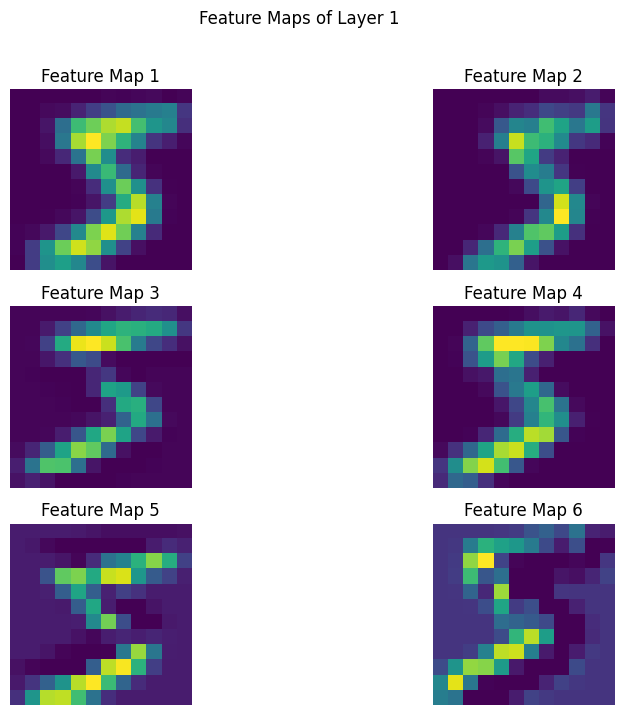

In [ ]:
# Choose an index for the sample you want to visualize
sample_index = 0
sample_image = x_train[sample_index]

# Visualize feature maps of the second Conv2D layer
visualize_feature_maps(model, sample_image, layer_index=1)

1/1 [==============================] - 0s 75ms/step
Size of Feature Maps: (8, 8, 16)


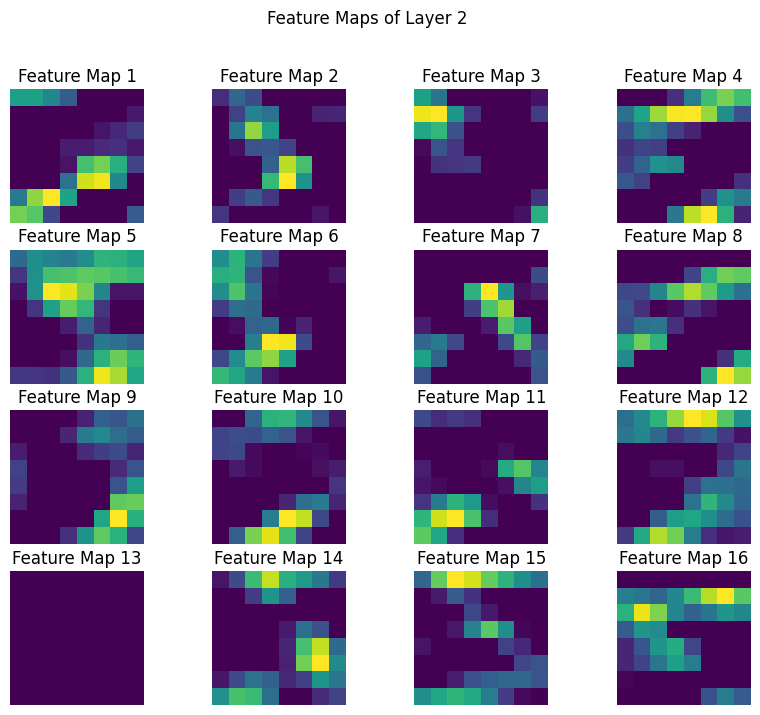

In [ ]:
# Choose an index for the sample you want to visualize
sample_index = 0
sample_image = x_train[sample_index]

# Visualize feature maps of the second Conv2D layer
visualize_feature_maps(model, sample_image, layer_index=2)

1/1 [==============================] - 0s 54ms/step
Size of Feature Maps: (4, 4, 16)


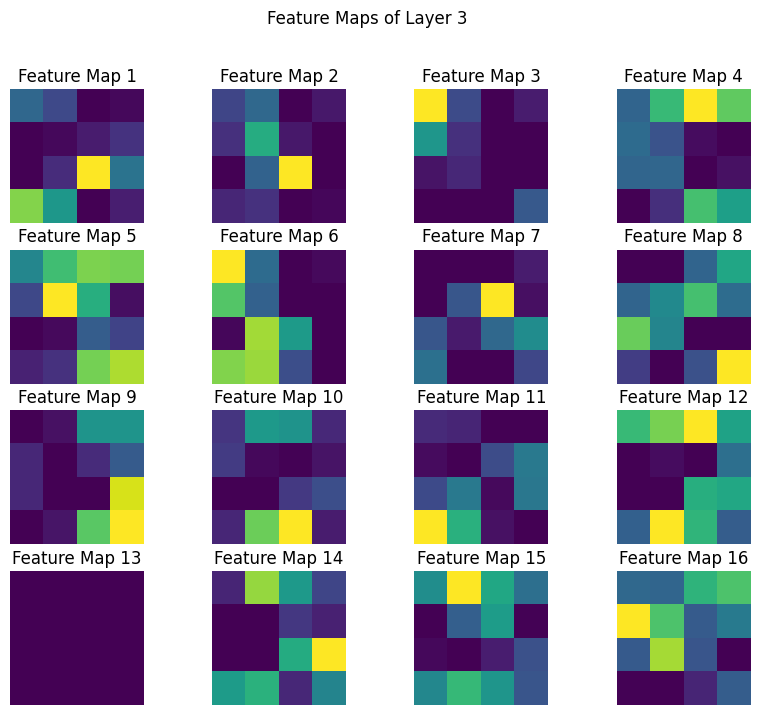

In [ ]:
# Choose an index for the sample you want to visualize
sample_index = 0
sample_image = x_train[sample_index]

# Visualize feature maps of the second Conv2D layer
visualize_feature_maps(model, sample_image, layer_index=3)

### Paper Summary

LeNet-5 is a convolutional neural network (CNN) developed by Yann LeCun and collaborators in the 1990s. It was specifically designed for handwritten digit recognition and is considered a pioneering architecture in the field. Below is a breakdown of its layers:

- C1 (Convolutional Layer):
  - 6 feature maps
  - Each unit connected to a 5x5 neighborhood in the input
  - Feature map size: 28x28
  - 156 trainable parameters
  - 122,304 connections

- S2 (Subsampling Layer):
  - 6 feature maps of size 14x14
  - Each unit connected to a 2x2 neighborhood in the corresponding feature map in C1
  - Non-overlapping receptive fields
  - 12 trainable parameters
  - 5,880 connections

- C3 (Convolutional Layer):
  - 16 feature maps
  - Each unit connected to 5x5 neighborhoods in a subset of S2's feature maps
  - Connection scheme designed for symmetry breaking and feature extraction diversity
  - 1,516 trainable parameters
  - 156,000 connections

- S4 (Subsampling Layer):
  - 16 feature maps of size 5x5
  - Each unit connected to a 2x2 neighborhood in the corresponding feature map in C3
  - 32 trainable parameters
  - 2,000 connections

- C5 (Convolutional Layer):
  - 120 feature maps
  - Each unit connected to a 5x5 neighborhood on all 16 of S4's feature maps
  - Essentially a fully connected layer due to the small feature map size of S4 (5x5)
  - 48,120 trainable connections

- F6 (Fully Connected Layer):
  - 84 units
  - Fully connected to C5
  - 10,164 trainable parameters

LeNet-5 typically concludes with an output layer for digit classification, with 10 units corresponding to the digits 0-9. The output layer uses a softmax activation function to produce probability scores for each digit class.


## 1D Conv


**Download these Files to run this Code**

https://drive.google.com/file/d/1BRr9BNaycsD1rGAMnyzZcEmH3YwGT_T5/view?usp=drive_link

https://drive.google.com/file/d/11ojK8P4ZRd4Q_DjAts9YvFrSB7jibz0F/view?usp=drive_link

https://drive.google.com/file/d/1-METJc2RV51OlO2fia60KkejOxazCwg1/view?usp=drive_link

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Load data
hand_data = pd.read_csv("./hand_pamap2.csv")
chest_data = pd.read_csv("./chest_pamap2.csv")
ankle_data = pd.read_csv("./ankle_pamap2.csv")

In [ ]:
hand_data.shape,chest_data.shape,ankle_data.shape

((1936481, 8), (1936481, 8), (1936481, 8))

In [ ]:
hand_data.info(),chest_data.info(),chest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936481 entries, 0 to 1936480
Data columns (total 8 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   hand_3D_acceleration_6_x  float64
 1   hand_3D_acceleration_6_y  float64
 2   hand_3D_acceleration_6_z  float64
 3   hand_3D_gyroscope_x       float64
 4   hand_3D_gyroscope_y       float64
 5   hand_3D_gyroscope_z       float64
 6   activity_id               int64  
 7   id                        int64  
dtypes: float64(6), int64(2)
memory usage: 118.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936481 entries, 0 to 1936480
Data columns (total 8 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   chest_3D_acceleration_6_x  float64
 1   chest_3D_acceleration_6_y  float64
 2   chest_3D_acceleration_6_z  float64
 3   chest_3D_gyroscope_x       float64
 4   chest_3D_gyroscope_y       float64
 5   chest_3D_gyroscope_z       float64
 6   activity_

(None, None, None)

In [ ]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

def angles_features(position, df):

    columns_to_drop = ['activity_id', 'id']
    dropped_columns = df[columns_to_drop]
    df = df.drop(columns=columns_to_drop)

    df['gyro_tan_expr1'] = np.arctan(df[f'{position}_3D_gyroscope_x'] / np.sqrt(df[f'{position}_3D_gyroscope_x']**2 + df[f'{position}_3D_gyroscope_y']**2 + df[f'{position}_3D_gyroscope_z']**2))
    df['gyro_tan_expr2'] = np.arctan(df[f'{position}_3D_gyroscope_x'] / np.sqrt(df[f'{position}_3D_gyroscope_y']**2 + df[f'{position}_3D_gyroscope_z']**2))
    df['gyro_tan_expr3'] = np.arctan(df[f'{position}_3D_gyroscope_y'] / np.sqrt(df[f'{position}_3D_gyroscope_z']**2 + df[f'{position}_3D_gyroscope_x']**2))
    df['gyro_tan_expr4'] = np.arctan(np.sqrt(df[f'{position}_3D_gyroscope_x']**2 + df[f'{position}_3D_gyroscope_y']**2) / df[f'{position}_3D_gyroscope_z'])
    df['gyro_tan_expr5'] = np.arctan(np.sqrt(df[f'{position}_3D_gyroscope_y']**2 + df[f'{position}_3D_gyroscope_z']**2) / df[f'{position}_3D_gyroscope_x'])
    df['gyro_tan_expr6'] = np.arctan(np.sqrt(df[f'{position}_3D_gyroscope_x']**2 + df[f'{position}_3D_gyroscope_z']**2) / df[f'{position}_3D_gyroscope_y'])
    df['gyro_tan2_expr7'] = np.arctan2(np.sqrt(df[f'{position}_3D_gyroscope_x']**2 + df[f'{position}_3D_gyroscope_z']**2), -df[f'{position}_3D_gyroscope_y'])

    df['tan_expr1'] = np.arctan(df[f'{position}_3D_acceleration_6_x'] / np.sqrt(df[f'{position}_3D_acceleration_6_x']**2 + df[f'{position}_3D_acceleration_6_y']**2 + df[f'{position}_3D_acceleration_6_z']**2))
    df['tan_expr2'] = np.arctan(df[f'{position}_3D_acceleration_6_x'] / np.sqrt(df[f'{position}_3D_acceleration_6_y']**2 + df[f'{position}_3D_acceleration_6_z']**2))
    df['tan_expr3'] = np.arctan(df[f'{position}_3D_acceleration_6_y'] / np.sqrt(df[f'{position}_3D_acceleration_6_z']**2 + df[f'{position}_3D_acceleration_6_x']**2))
    df['tan_expr4'] = np.arctan(np.sqrt(df[f'{position}_3D_acceleration_6_x']**2 + df[f'{position}_3D_acceleration_6_y']**2) / df[f'{position}_3D_acceleration_6_z'])
    df['tan_expr5'] = np.arctan(np.sqrt(df[f'{position}_3D_acceleration_6_y']**2 + df[f'{position}_3D_acceleration_6_z']**2) / df[f'{position}_3D_acceleration_6_x'])
    df['tan_expr6'] = np.arctan(np.sqrt(df[f'{position}_3D_acceleration_6_x']**2 + df[f'{position}_3D_acceleration_6_z']**2) / df[f'{position}_3D_acceleration_6_y'])
    df['tan2_expr7'] = np.arctan2(np.sqrt(df[f'{position}_3D_acceleration_6_x']**2 + df[f'{position}_3D_acceleration_6_z']**2), -df[f'{position}_3D_acceleration_6_y'])

    df = pd.concat([df, dropped_columns], axis=1)

    return df

def windows_and_spliting(df, window_size, overlap):
    try:
        # Check if DataFrame is empty
        if not df.empty:
            # Function to create windows with overlap
            def create_windows(data, window_size, overlap):
                windows = []
                labels = []

                step_size = window_size - overlap

                for i in range(0, len(data) - window_size + 1, step_size):
                    window = data.iloc[i:i + window_size, 0:-2].values  # Exclude id and label columns
                    label = data.iloc[i:i + window_size, -2].mode().values[0]
                    windows.append(window)
                    labels.append(label)

                return np.array(windows), np.array(labels)

            # Function to preprocess data
            def preprocess_data(data, window_size, overlap):
                X, y = create_windows(data, window_size, overlap)

                label_encoder = LabelEncoder()
                y = label_encoder.fit_transform(y)

                return X, y

            windows, labels = preprocess_data(df, window_size, overlap)

            X_train, X_test, y_train, y_test = train_test_split(windows, labels, test_size=0.2, random_state=42)
            print("Training Data Shapes:")
            print(f"X_train.shape={X_train.shape} and X_train.shape[2]={X_train.shape[2]}, y_train.shape={y_train.shape}")
            print("\nTest Data Shapes:")
            print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")
            print()
            return X_train, X_test, y_train, y_test
        else:
            print("Skipping due to empty DataFrame.")
            return None, None, None, None
    except ValueError as e:
        print("Skipping due to error:", e)
        return None, None, None, None

    windows, labels = preprocess_data(df, window_size, overlap)

    X_train, X_test, y_train, y_test = train_test_split(windows, labels, test_size=0.2, random_state=42)
    print("Training Data Shapes:")
    print(f"X_train.shape={X_train.shape} and X_train.shape[2]={X_train.shape[2]}, y_train.shape={y_train.shape}")
    print("\nTest Data Shapes:")
    print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")
    print()
    return X_train, X_test, y_train, y_test

In [ ]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, num_classes):
    # Define CNN architecture
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer with num_classes
    ])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Accuracy:", accuracy)

    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute evaluation metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

### Same Position and Across Positions

In [ ]:
# Set window size and overlap
window_size = 100
overlap = 50

# Calculate the number of unique activity IDs
num_classes = len(np.unique(np.concatenate((hand_data['activity_id'], ankle_data['activity_id'], chest_data['activity_id']))))

# Preprocess data for different positions
X_train_hand, X_test_hand, y_train_hand, y_test_hand = windows_and_spliting(hand_data, window_size, overlap)
X_train_ankle, X_test_ankle, y_train_ankle, y_test_ankle = windows_and_spliting(ankle_data, window_size, overlap)
X_train_chest, X_test_chest, y_train_chest, y_test_chest = windows_and_spliting(chest_data, window_size, overlap)

# Train and evaluate models within the same position
print("Training and evaluating models within the same position - Hand")
train_and_evaluate_model(X_train_hand, X_test_hand, y_train_hand, y_test_hand)

print("Training and evaluating models within the same position - Ankle")
train_and_evaluate_model(X_train_ankle, X_test_ankle, y_train_ankle, y_test_ankle)

print("Training and evaluating models within the same position - Chest")
train_and_evaluate_model(X_train_chest, X_test_chest, y_train_chest, y_test_chest)

# Concatenate data for different positions
X_train_all = np.concatenate((X_train_hand, X_train_ankle, X_train_chest), axis=0)
X_test_all = np.concatenate((X_test_hand, X_test_ankle, X_test_chest), axis=0)
y_train_all = np.concatenate((y_train_hand, y_train_ankle, y_train_chest), axis=0)
y_test_all = np.concatenate((y_test_hand, y_test_ankle, y_test_chest), axis=0)

# Train and evaluate model across positions
print("Training and evaluating model across all positions")
train_and_evaluate_model(X_train_all, X_test_all, y_train_all, y_test_all)

Training Data Shapes:
X_train.shape=(30982, 100, 6) and X_train.shape[2]=6, y_train.shape=(30982,)

Test Data Shapes:
X_test.shape=(7746, 100, 6), y_test.shape=(7746,)

Training Data Shapes:
X_train.shape=(30982, 100, 6) and X_train.shape[2]=6, y_train.shape=(30982,)

Test Data Shapes:
X_test.shape=(7746, 100, 6), y_test.shape=(7746,)

Training Data Shapes:
X_train.shape=(30982, 100, 6) and X_train.shape[2]=6, y_train.shape=(30982,)

Test Data Shapes:
X_test.shape=(7746, 100, 6), y_test.shape=(7746,)

Training and evaluating models within the same position - Hand
Epoch 1/10
388/388 [==============================] - 8s 19ms/step - loss: 1.0612 - accuracy: 0.6811 - val_loss: 0.7651 - val_accuracy: 0.7725
Epoch 2/10
388/388 [==============================] - 5s 14ms/step - loss: 0.6939 - accuracy: 0.7970 - val_loss: 0.6720 - val_accuracy: 0.8096
Epoch 3/10
388/388 [==============================] - 7s 17ms/step - loss: 0.5949 - accuracy: 0.8258 - val_loss: 0.6437 - val_accuracy: 0.8154
E

### User-Wise on Same Position and Cross Position

In [ ]:
# Print unique values of 'id' column in each data file
print("Unique IDs in hand_data:", hand_data['id'].unique())
print("Unique IDs in chest_data:", chest_data['id'].unique())
print("Unique IDs in ankle_data:", ankle_data['id'].unique())

Unique IDs in hand_data: [101 102 103 104 105 106 107 108]
Unique IDs in chest_data: [101 102 103 104 105 106 107 108]
Unique IDs in ankle_data: [101 102 103 104 105 106 107 108]


In [ ]:
# Set window size and overlap
window_size = 100
overlap = 50

def train_and_evaluate_model(X_train, X_test, y_train, y_test, num_classes):
    # Define CNN architecture
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer with num_classes
    ])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Accuracy:", accuracy)

    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute evaluation metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


# Function to preprocess data, train, and evaluate model for each user
def preprocess_train_evaluate_by_user(data, window_size, overlap,num_classes):
    unique_ids = data['id'].unique()
    for user_id in unique_ids:
        user_data = data[data['id'] == user_id]
        X_train, X_test, y_train, y_test = windows_and_spliting(user_data, window_size, overlap)
        print(f"Training and evaluating models for User {user_id}")
        train_and_evaluate_model(X_train, X_test, y_train, y_test,num_classes)

# Function to concatenate data for different positions and train and evaluate model across positions for each user
def train_evaluate_across_positions_by_user(hand_data, ankle_data, chest_data, window_size, overlap, num_classes):
    unique_ids_hand = hand_data['id'].unique()
    unique_ids_ankle = ankle_data['id'].unique()
    unique_ids_chest = chest_data['id'].unique()
    common_ids = set(unique_ids_hand) & set(unique_ids_ankle) & set(unique_ids_chest)

    for user_id in common_ids:
        hand_user_data = hand_data[hand_data['id'] == user_id]
        ankle_user_data = ankle_data[ankle_data['id'] == user_id]
        chest_user_data = chest_data[chest_data['id'] == user_id]

        X_train_hand, X_test_hand, y_train_hand, y_test_hand = windows_and_spliting(hand_user_data, window_size, overlap)
        X_train_ankle, X_test_ankle, y_train_ankle, y_test_ankle = windows_and_spliting(ankle_user_data, window_size, overlap)
        X_train_chest, X_test_chest, y_train_chest, y_test_chest = windows_and_spliting(chest_user_data, window_size, overlap)

        X_train_all = np.concatenate((X_train_hand, X_train_ankle, X_train_chest), axis=0)
        X_test_all = np.concatenate((X_test_hand, X_test_ankle, X_test_chest), axis=0)
        y_train_all = np.concatenate((y_train_hand, y_train_ankle, y_train_chest), axis=0)
        y_test_all = np.concatenate((y_test_hand, y_test_ankle, y_test_chest), axis=0)

        print(f"Training and evaluating model across all positions for User {user_id}")
        train_and_evaluate_model(X_train_all, X_test_all, y_train_all, y_test_all, num_classes)

# Calculate the number of unique activity IDs
num_classes = len(np.unique(np.concatenate((hand_data['activity_id'], ankle_data['activity_id'], chest_data['activity_id']))))

# Preprocess data, train, and evaluate models for each user within the same position
print("Training and evaluating models within the same position - Hand")
preprocess_train_evaluate_by_user(hand_data, window_size, overlap,num_classes)

print("Training and evaluating models within the same position - Ankle")
preprocess_train_evaluate_by_user(ankle_data, window_size, overlap,num_classes)

print("Training and evaluating models within the same position - Chest")
preprocess_train_evaluate_by_user(chest_data, window_size, overlap,num_classes)

# Train and evaluate model across positions for each user
train_evaluate_across_positions_by_user(hand_data, ankle_data, chest_data, window_size, overlap, num_classes)

Training and evaluating models within the same position - Hand
Training Data Shapes:
X_train.shape=(3998, 100, 6) and X_train.shape[2]=6, y_train.shape=(3998,)

Test Data Shapes:
X_test.shape=(1000, 100, 6), y_test.shape=(1000,)

Training and evaluating models for User 101
Epoch 1/10
50/50 [==============================] - 2s 19ms/step - loss: 1.7033 - accuracy: 0.5094 - val_loss: 1.0636 - val_accuracy: 0.6700
Epoch 2/10
50/50 [==============================] - 1s 16ms/step - loss: 0.7827 - accuracy: 0.7799 - val_loss: 0.7575 - val_accuracy: 0.7675
Epoch 3/10
50/50 [==============================] - 1s 15ms/step - loss: 0.5788 - accuracy: 0.8368 - val_loss: 0.6289 - val_accuracy: 0.8025
Epoch 4/10
50/50 [==============================] - 1s 15ms/step - loss: 0.4931 - accuracy: 0.8612 - val_loss: 0.5636 - val_accuracy: 0.8450
Epoch 5/10
50/50 [==============================] - 1s 15ms/step - loss: 0.4217 - accuracy: 0.8806 - val_loss: 0.5374 - val_accuracy: 0.8500
Epoch 6/10
50/50 [===

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Data Shapes:
X_train.shape=(3723, 100, 6) and X_train.shape[2]=6, y_train.shape=(3723,)

Test Data Shapes:
X_test.shape=(931, 100, 6), y_test.shape=(931,)

Training and evaluating models for User 107
Epoch 1/10
47/47 [==============================] - 3s 33ms/step - loss: 1.9186 - accuracy: 0.4463 - val_loss: 1.1268 - val_accuracy: 0.5879
Epoch 2/10
47/47 [==============================] - 1s 20ms/step - loss: 0.9197 - accuracy: 0.6760 - val_loss: 0.8927 - val_accuracy: 0.7087
Epoch 3/10
47/47 [==============================] - 1s 15ms/step - loss: 0.7025 - accuracy: 0.7834 - val_loss: 0.8059 - val_accuracy: 0.7611
Epoch 4/10
47/47 [==============================] - 1s 15ms/step - loss: 0.5888 - accuracy: 0.8224 - val_loss: 0.6953 - val_accuracy: 0.8121
Epoch 5/10
47/47 [==============================] - 1s 15ms/step - loss: 0.5231 - accuracy: 0.8445 - val_loss: 0.6868 - val_accuracy: 0.8027
Epoch 6/10
47/47 [==============================] - 1s 16ms/step - loss: 0.4875 - accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Data Shapes:
X_train.shape=(3723, 100, 6) and X_train.shape[2]=6, y_train.shape=(3723,)

Test Data Shapes:
X_test.shape=(931, 100, 6), y_test.shape=(931,)

Training and evaluating models for User 107
Epoch 1/10
47/47 [==============================] - 2s 20ms/step - loss: 1.5515 - accuracy: 0.5329 - val_loss: 0.9405 - val_accuracy: 0.7718
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.7059 - accuracy: 0.8136 - val_loss: 0.7206 - val_accuracy: 0.8134
Epoch 3/10
47/47 [==============================] - 1s 16ms/step - loss: 0.5760 - accuracy: 0.8482 - val_loss: 0.6497 - val_accuracy: 0.8362
Epoch 4/10
47/47 [==============================] - 1s 16ms/step - loss: 0.4700 - accuracy: 0.8731 - val_loss: 0.5898 - val_accuracy: 0.8564
Epoch 5/10
47/47 [==============================] - 1s 16ms/step - loss: 0.4096 - accuracy: 0.8939 - val_loss: 0.5440 - val_accuracy: 0.8591
Epoch 6/10
47/47 [==============================] - 1s 15ms/step - loss: 0.3705 - accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Data Shapes:
X_train.shape=(3723, 100, 6) and X_train.shape[2]=6, y_train.shape=(3723,)

Test Data Shapes:
X_test.shape=(931, 100, 6), y_test.shape=(931,)

Training Data Shapes:
X_train.shape=(3723, 100, 6) and X_train.shape[2]=6, y_train.shape=(3723,)

Test Data Shapes:
X_test.shape=(931, 100, 6), y_test.shape=(931,)

Training Data Shapes:
X_train.shape=(3723, 100, 6) and X_train.shape[2]=6, y_train.shape=(3723,)

Test Data Shapes:
X_test.shape=(931, 100, 6), y_test.shape=(931,)

Training and evaluating model across all positions for User 107
Epoch 1/10
140/140 [==============================] - 3s 16ms/step - loss: 1.4409 - accuracy: 0.5513 - val_loss: 1.3582 - val_accuracy: 0.5595
Epoch 2/10
140/140 [==============================] - 3s 20ms/step - loss: 0.8372 - accuracy: 0.7341 - val_loss: 1.1423 - val_accuracy: 0.5989
Epoch 3/10
140/140 [==============================] - 3s 21ms/step - loss: 0.6590 - accuracy: 0.7965 - val_loss: 1.0067 - val_accuracy: 0.6195
Epoch 4/10
1

## Types of Convolution

In [ ]:
import numpy as np
import tensorflow as tf

# Input data
input_data = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]], dtype=np.float32)
input_tensor = tf.constant(input_data.reshape(1, 3, 3, 1))  # Reshape to (batch_size, height, width, channels)

In [ ]:
# Convolutional layer
conv_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='valid', use_bias=False)

# Apply convolution
output_data = conv_layer(input_tensor)

print("Normal Convolution Output:")
print(output_data.numpy().squeeze())


Normal Convolution Output:
3.6818051


In [ ]:
# Depthwise convolutional layer
depthwise_conv_layer = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='valid', use_bias=False)

# Apply depthwise convolution
output_data_depthwise = depthwise_conv_layer(input_tensor)

print("\nDepthwise Convolution Output:")
print(output_data_depthwise.numpy().squeeze())


Depthwise Convolution Output:
-4.6420503


In [ ]:
# Pointwise convolutional layer
pointwise_conv_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='valid', use_bias=False)

# Apply pointwise convolution
output_data_pointwise = pointwise_conv_layer(output_data_depthwise)

print("\nPointwise Convolution Output:")
print(output_data_pointwise.numpy().squeeze())


Pointwise Convolution Output:
-1.5018418


In [ ]:
# Separable convolution
separable_conv_layer = tf.keras.layers.SeparableConv2D(filters=1, kernel_size=3, strides=1, padding='valid', use_bias=False)

# Apply separable convolution
output_data_separable = separable_conv_layer(input_tensor)

print("\nSeparable Convolution Output:")
print(output_data_separable.numpy().squeeze())


Separable Convolution Output:
0.035226524


1. Normal Convolution:
   - Applies a filter to the entire input volume, capturing spatial patterns and inter-channel interactions.
   - Involves a large number of parameters and computational cost.
   
2. Depthwise Convolution:
   - Applies a single filter to each input channel separately, capturing spatial patterns within each channel independently.
   - Significantly reduces the number of parameters and computational cost compared to normal convolution.

3. Pointwise Convolution:
   - Applies a 1x1 filter to the output of depthwise convolution, enabling cross-channel interactions.
   - Adjusts the depth of feature maps and learns interactions between different channels.
   - More efficient than normal convolution but adds some computational overhead.

4. Separable Convolution:
   - Combines depthwise and pointwise convolutions.
   - First applies depthwise convolution to capture spatial patterns within each channel.
   - Then applies pointwise convolution to learn cross-channel interactions.
   - Achieves a balance between computational efficiency and expressive power.
   
Differences:
- Parameter Efficiency: Depthwise > Separable > Normal Convolution
- Computational Efficiency: Depthwise > Separable > Normal Convolution
- Inter-channel Interactions: Normal > Pointwise > Depthwise
- Flexibility vs. Efficiency: Normal > Separable > Depthwise


## Types of Convolution Neural Network

1. AlexNet:
   - Architecture: Eight layers including five convolutional layers and three fully connected layers.
   - Key Innovations: ReLU (Rectified Linear Unit) activation, LRN (Local Response Normalization), dropout, parallelization.
   - Size: Relatively smaller compared to later architectures.

2. VGG (Visual Geometry Group):
   - Architecture: Sixteen convolutional layers followed by max-pooling layers and three fully connected layers.
   - Depth: Deeper architecture with emphasis on uniformity.
   - Parameters: More parameters due to depth and uniformity.
   - Pre-Trained Models: Widely used for transfer learning.

3. ResNet (Residual Network):
   - Architecture: A residual refers to the difference between the desired output and the actual output of a layer.
   - Skip Connections: Introduces skip or shortcut connections bypassing one or more layers.
   - Depth: Can be substantially deeper than VGG or AlexNet.
   - Performance: State-of-the-art performance in various image recognition tasks.

4. Inception:
   - Architecture: Inception networks feature multiple parallel convolutional paths of different kernel sizes, including 1x1, 3x3, and 5x5 convolutions, along with pooling operations.
   - Computational Progress: Inception architectures provide good performance by efficiently capturing features at multiple scales. They achieve this with moderate computational costs compared to deeper architectures.

5. MobileNet:
   - Architecture: MobileNet architectures are designed to be lightweight and suitable for mobile and embedded devices. They employ depthwise separable convolutions, consisting of depthwise convolutions followed by pointwise convolutions, to reduce computation.
   - Computational Progress: MobileNet significantly reduces the number of parameters compared to traditional architectures by employing depthwise separable convolutions. This reduction in parameters leads to lower computational requirements, making it suitable for deployment on resource-constrained devices.

6. EfficientNet:
   - Architecture: EfficientNet architectures optimize both depth, width, and resolution scaling to achieve state-of-the-art performance. They systematically scale network dimensions using a compound scaling method, balancing between model size and accuracy.
   - Computational Progress: EfficientNet architectures provide better performance compared to other architectures with similar computational costs. By scaling network dimensions efficiently, they achieve superior accuracy while maintaining reasonable computational requirements, suitable for a wide range of deployment scenarios.

**Why do residual networks work?**

- Residual connections mitigate vanishing gradient problem.
- Direct gradient flow facilitates optimization.
- Encourages feature reuse for better generalization.
- Enables training of very deep networks.
- Implicit regularization effect helps prevent overfitting.


**1x1 Convolution**

- 1x1 convolutions reduce dimensionality.
- They perform non-linear transformations.
- Commonly used in deep networks to increase expressiveness.
- Used in Inception modules for efficient feature extraction.
- Allow cross-channel information exchange.


In [ ]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
from efficientnet.tfkeras import EfficientNetB0

train = int(1000)
test = int(250)

# Load a smaller portion of CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images, test_images = train_images[:train] / 255.0, test_images[:test] / 255.0  # Using the first 1000 training images and first 250 test images
train_labels, test_labels = to_categorical(train_labels[:train]), to_categorical(test_labels[:test])  # Corresponding labels

# Resize images for AlexNet (227x227 pixels)
train_images_alexnet = tf.image.resize(train_images, (227, 227))
test_images_alexnet = tf.image.resize(test_images, (227, 227))

# Resize images for VGG16, ResNet50, and EfficientNetB0 (224x224 pixels)
train_images_common = tf.image.resize(train_images, (224, 224))
test_images_common = tf.image.resize(test_images, (224, 224))

# Resize images for InceptionV3 (299x299 pixels)
train_images_inception = tf.image.resize(train_images, (299, 299))
test_images_inception = tf.image.resize(test_images, (299, 299))

# Define AlexNet architecture
def alexnet_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Instantiate AlexNet model
alexnet = alexnet_model(input_shape=train_images_alexnet[0].shape, num_classes=10)

# Define other models with adjusted output shape
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_output = tf.keras.layers.GlobalAveragePooling2D()(vgg.output)
vgg_output = tf.keras.layers.Dense(10, activation='softmax')(vgg_output)
vgg_model = tf.keras.Model(inputs=vgg.input, outputs=vgg_output)

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_output = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
resnet_output = tf.keras.layers.Dense(10, activation='softmax')(resnet_output)
resnet_model = tf.keras.Model(inputs=resnet.input, outputs=resnet_output)

inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
inception_output = tf.keras.layers.GlobalAveragePooling2D()(inception.output)
inception_output = tf.keras.layers.Dense(10, activation='softmax')(inception_output)
inception_model = tf.keras.Model(inputs=inception.input, outputs=inception_output)

mobilenet = MobileNet(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
mobilenet_output = tf.keras.layers.GlobalAveragePooling2D()(mobilenet.output)
mobilenet_output = tf.keras.layers.Dense(10, activation='softmax')(mobilenet_output)
mobilenet_model = tf.keras.Model(inputs=mobilenet.input, outputs=mobilenet_output)

efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_output = tf.keras.layers.GlobalAveragePooling2D()(efficientnet.output)
efficientnet_output = tf.keras.layers.Dense(10, activation='softmax')(efficientnet_output)
efficientnet_model = tf.keras.Model(inputs=efficientnet.input, outputs=efficientnet_output)

# Train and evaluate each model
models = {
    'AlexNet': alexnet,
    'VGG16': vgg_model,
    'ResNet50': resnet_model,
    'InceptionV3': inception_model,
    'MobileNet': mobilenet_model,
    'EfficientNetB0': efficientnet_model
}

histories = {}
for model_name, model in models.items():
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {model_name}...")
    if model_name == 'AlexNet':
        history = model.fit(train_images_alexnet, train_labels, epochs=1,
                            validation_data=(test_images_alexnet, test_labels))
    elif model_name == 'InceptionV3':
        history = model.fit(train_images_inception, train_labels, epochs=1,
                            validation_data=(test_images_inception, test_labels))
    else:
        history = model.fit(train_images_common, train_labels, epochs=1,
                            validation_data=(test_images_common, test_labels))
    histories[model_name] = history

# Compare performance
for model_name, history in histories.items():
    print(f"\n{model_name}:")
    print(f"Train Accuracy: {history.history['accuracy'][-1]}")
    print(f"Test Accuracy: {history.history['val_accuracy'][-1]}")


Training AlexNet...
32/32 [==============================] - 4s 51ms/step - loss: 2.3455 - accuracy: 0.0900 - val_loss: 2.3033 - val_accuracy: 0.0800
Training VGG16...
32/32 [==============================] - 48s 788ms/step - loss: 2.3798 - accuracy: 0.1000 - val_loss: 2.3017 - val_accuracy: 0.1160
Training ResNet50...
32/32 [==============================] - 50s 486ms/step - loss: 2.1467 - accuracy: 0.3130 - val_loss: 2.6803 - val_accuracy: 0.1000
Training InceptionV3...
32/32 [==============================] - 70s 835ms/step - loss: 1.6551 - accuracy: 0.4340 - val_loss: 1587.3287 - val_accuracy: 0.1160
Training MobileNet...
32/32 [==============================] - 20s 195ms/step - loss: 1.4308 - accuracy: 0.5610 - val_loss: 6.6213 - val_accuracy: 0.1400
Training EfficientNetB0...
32/32 [==============================] - 48s 439ms/step - loss: 1.1051 - accuracy: 0.6310 - val_loss: 1.9515 - val_accuracy: 0.2960

AlexNet:
Train Accuracy: 0.09000000357627869
Test Accuracy: 0.079999998211

Utilizing only 1000 input samples for training and 250 for testing, and trained for just 1 epoch, it's clear that MobileNet and EfficientNetB0 exhibit remarkable learning speed and computational efficiency, surpassing other models evaluated. Their lightweight architectures and minimal computational demands render them highly desirable choices for real-world applications.
